In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

from sklearn import linear_model
import pandas as pd

In [2]:
def pinball_loss(data, quant_preds, quantiles):
    loss = 0
    for t in range(len(data)):
        for i in range(len(quantiles)):
            q = quantiles[i]
            quant_pred = quant_preds[t][i]
            if quant_pred > data[t]:
                loss += (quant_pred - data[t]) * (1 - q)
            else:
                loss += (data[t] - quant_pred) * q
    return loss / (len(data) * len(quantiles))

In [106]:
meter_id = 11
finals_df = pd.read_csv(".\\GEFCom2017\\GEFCom2017-Final\\load.csv")
finals_df = finals_df[finals_df.meter_id==meter_id]

In [107]:
finals_df

,meter_id,date,h1,h2,h3,h4,h5,h6,h7,h8,...,h15,h16,h17,h18,h19,h20,h21,h22,h23,h24
22691,11,1/1/2005,10577.0,9854.0,9538.0,9600.0,9775.0,10337.0,11184.0,12096.0,...,10097,10046,10337,11537,12271,12065,11630,11184,10402,9247
22692,11,1/2/2005,8448.0,7999.0,7824.0,8016.0,8290.0,8976.0,9792.0,11023.0,...,9696,9343,9744,11201,12017,11966,11633,10975,9936,8897
22693,11,1/3/2005,8239.0,7968.0,7697.0,7951.0,9024.0,10560.0,12017.0,12384.0,...,9600,9394,9648,10848,12895,12960,12624,11537,9950,8688
22694,11,1/4/2005,7985.0,7663.0,7649.0,7711.0,8482.0,10111.0,12480.0,12175.0,...,8674,8606,9216,10786,12271,12161,11839,10783,9312,7937
22695,11,1/5/2005,7135.0,6768.0,6754.0,7039.0,7841.0,9504.0,11870.0,11921.0,...,8640,8609,9487,11280,12754,12638,12257,11681,10159,8417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25242,11,12/27/2011,10399.0,10032.0,9888.0,9967.0,10210.0,10800.0,11839.0,12943.0,...,12864,12703,12977,14239,15185,15089,15007,14383,13361,12384
25243,11,12/28/2011,11743.0,11328.0,11153.0,11263.0,11616.0,12257.0,13296.0,14143.0,...,10975,10961,11983,13937,15233,15230,15360,15072,14609,13807
25244,11,12/29/2011,13522.0,13519.0,13889.0,14448.0,15134.0,16193.0,17777.0,18446.0,...,11633,11520,12240,14177,15583,16255,16258,15888,15278,14386
25245,11,12/30/2011,13728.0,13375.0,13152.0,13344.0,13663.0,14304.0,15346.0,16399.0,...,10591,10642,11102,12672,13505,13135,12833,12048,11263,10241


In [108]:
loads = finals_df.iloc[:, 2:].to_numpy()
loads = loads.reshape(loads.size)
dates = finals_df.date.to_numpy().repeat(24)

In [109]:
temps_df = pd.read_csv(".\\GEFCom2017\\GEFCom2017-Final\\temperature.csv")

In [110]:
offset = 0
i = 0
while i < loads.shape[0]:
    if i % 24 + 1 != temps_df.hr.iloc[i]:
        print(i, temps_df.hr.iloc[i])
        idxs = temps_df.index.to_numpy()
        idxs[i:] += 1
        temps_df.index = idxs
        fake_data = (temps_df.loc[i - 1].iloc[1:] + temps_df.loc[i + 1].iloc[1:]) // 2
        fake_data = pd.DataFrame(fake_data).transpose()
        fake_data.index = [i]
        temps_df = temps_df.append(fake_data, sort=True)
        temps_df.date[i] = temps_df.date[i + 1]
        temps_df = temps_df.sort_index()
        i += 1
    i += 1

2209 3
10945 3
19177 3
27913 3
36649 3
45553 3
54289 3


In [111]:
temps = temps_df.iloc[:, 2:].mean(axis=1)

In [112]:
finals_df = pd.DataFrame({"date": dates, "load": loads, "temp": temps})

In [113]:
finals_df.date = pd.to_datetime(finals_df.date)

In [114]:
finals_df["day_of_week"] = list((i // 24) % 7 for i in range(len(finals_df)))
finals_df["hour_end"] = list(i % 24 + 1 for i in range(len(finals_df)))
finals_df["month"] = list(finals_df.date.loc[i].month for i in finals_df.index)
finals_df["day_of_year"] = list(date.timetuple().tm_yday for date in finals_df.date)
finals_df["year"] = list(date.timetuple().tm_year for date in finals_df.date)

In [115]:
finals_df

,date,load,temp,day_of_week,hour_end,month,day_of_year,year
0,2005-01-01,10577.0,46.107143,0,1,1,1,2005
1,2005-01-01,9854.0,45.964286,0,2,1,1,2005
2,2005-01-01,9538.0,44.964286,0,3,1,1,2005
3,2005-01-01,9600.0,45.178571,0,4,1,1,2005
4,2005-01-01,9775.0,44.714286,0,5,1,1,2005
...,...,...,...,...,...,...,...,...
61339,2011-12-31,13423.0,47.928571,0,20,12,365,2011
61340,2011-12-31,13121.0,45.250000,0,21,12,365,2011
61341,2011-12-31,12960.0,43.607143,0,22,12,365,2011
61342,2011-12-31,12528.0,41.964286,0,23,12,365,2011


In [116]:
bad_idxs = finals_df.load.isnull().to_numpy().nonzero()[0]
finals_df.loc[bad_idxs, "load"] = (finals_df.load.values[bad_idxs - 1] + finals_df.load.values[bad_idxs + 1]) / 2

In [117]:
finals_df.loc[bad_idxs, "load"]

2209     10303.0
10945     6639.5
19177     7608.0
27913    14016.0
36649     6264.0
45553     8487.5
54289     8335.0
Name: load, dtype: float64

In [118]:
variables = pd.DataFrame(finals_df.temp)

In [119]:
variables["temp2"] = variables.temp ** 2
variables["temp3"] = variables.temp ** 3
variables["trend"] = variables.index

for i in range(2, 13):
    variables[f"m{i}"] = (i == finals_df.month) * 1  # converts to int
    variables[f"tempmonth{i}"] = variables.temp * variables[f"m{i}"]
    variables[f"temp2month{i}"] = variables.temp2 * variables[f"m{i}"]
    variables[f"temp3month{i}"] = variables.temp3 * variables[f"m{i}"]

for i in range(2, 25):
    variables[f"h{i}"] = (i == finals_df.hour_end) * 1
    variables[f"temphour{i}"] = variables.temp * variables[f"h{i}"]
    variables[f"temp2hour{i}"] = variables.temp2 * variables[f"h{i}"]
    variables[f"temp3hour{i}"] = variables.temp3 * variables[f"h{i}"]

for i in range(1, 7):
    variables[f"w{i}"] = (i == finals_df.day_of_week) * 1
    
for i in range(1, 7):
    for j in range(2, 25):
        variables[f"wh{i}_{j}"] = variables[f"w{i}"] * variables[f"h{j}"]

# Train

In [120]:
# def test(all_demand, hours_of_day, all_temps, months_of_year, train_through=None, gap=0, test_through=None, plot=False):
train_through = finals_df[finals_df.date == pd.Timestamp("2011-01-01")].index[0]
cap = train_through
train_df = finals_df.iloc[:cap]
train_vars = variables.iloc[:cap]

In [121]:
train_vars[:50]

,temp,temp2,temp3,trend,m2,tempmonth2,temp2month2,temp3month2,m3,tempmonth3,...,wh6_15,wh6_16,wh6_17,wh6_18,wh6_19,wh6_20,wh6_21,wh6_22,wh6_23,wh6_24
0,46.107143,2125.868622,98017.728271,0,0,0.0,0.0,0.0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,45.964286,2112.715561,97109.461689,1,0,0.0,0.0,0.0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,44.964286,2021.786990,90908.207863,2,0,0.0,0.0,0.0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,45.178571,2041.103316,92214.131970,3,0,0.0,0.0,0.0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,44.714286,1999.367347,89400.282799,4,0,0.0,0.0,0.0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
5,43.750000,1914.062500,83740.234375,5,0,0.0,0.0,0.0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
6,43.892857,1926.582908,84563.228362,6,0,0.0,0.0,0.0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
7,44.214286,1954.903061,86434.642493,7,0,0.0,0.0,0.0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
8,47.928571,2297.147959,110099.020044,8,0,0.0,0.0,0.0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
9,53.607143,2873.725765,154052.227633,9,0,0.0,0.0,0.0,0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [122]:
reg = linear_model.LinearRegression()

reg.fit(train_vars, train_df.load)

LinearRegression()

<IPython.core.display.Javascript object>


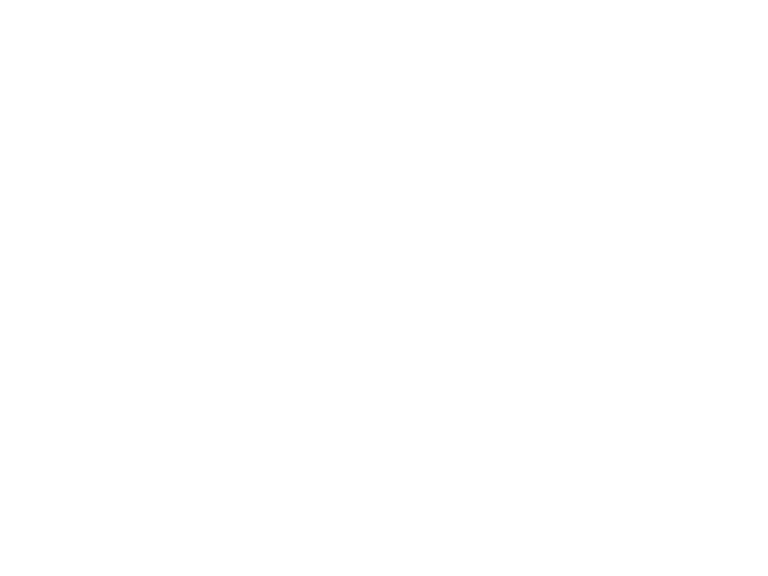

In [123]:
%matplotlib notebook 
fit = reg.predict(variables)
plt.figure()
plt.plot(finals_df.load)
plt.plot(fit)
plt.axvline(train_through, color="k")
plt.show()

# Test

In [128]:
#  ###---TEST---###
gap = 52 * 24
test_length = 31 * 24
start = train_through + gap
cap = train_through + test_length + gap
test_demand = finals_df.load[start:cap]
test_days_of_year = np.unique(finals_df.day_of_year.iloc[start:cap].values)

temps = []
years = np.unique(train_df.year)
num_years = len(years)
k = int((99 / num_years - 1) / 2 + 0.5)
print("k =", k)
for yr in years:
    this_year = train_df[train_df.year == yr]
    for shift in range(-k, k + 1):
        include = list(day + shift in test_days_of_year for day in this_year.day_of_year)
        temps.append(this_year.temp[include].values)
# dates = [[]]
# for date in train_df.date:
#     ignore_year = list(test_date.replace(year=2000) for test_date in test_dates)
#     if date.replace(year=2000) in ignore_year:
#         if len(dates[-1]) == test_length:
#             dates.append([])
#         dates[-1].append(date)
    
# for shift in range(-k, k + 1):
#     print(k)
#     delta = pd.Timedelta(days=shift)
#     for dates_list in dates:
#         idxs = list(date + delta in dates_list for date in train_df.date)
#         temps.append(train_df.temp[idxs])

k = 8


In [129]:
diff = np.mean(temps) - variables.temp[start:cap].values

<IPython.core.display.Javascript object>


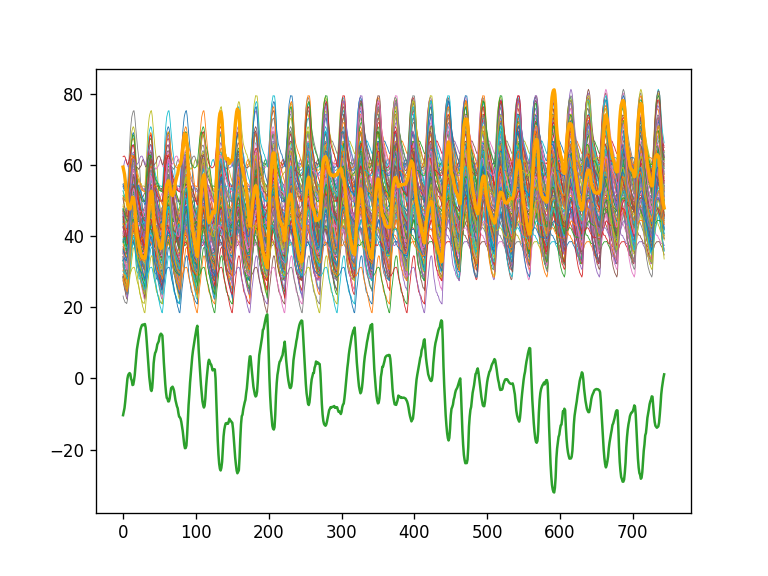

In [130]:
%matplotlib notebook
plt.plot(np.array(temps).T, linewidth=0.5)
plt.plot(variables.temp[start:cap].values, linewidth=2, color="orange")
plt.plot(diff)
plt.show()

In [131]:
preds = []
for i, temp in enumerate(temps):
    test_vars = variables.iloc[start:cap]
    
    test_vars.loc[:, "temp"] = temp
    test_vars.loc[:, "temp2"] = temp ** 2
    test_vars.loc[:, "temp3"] = temp ** 3

    for i in range(2, 13):
        test_vars.loc[:, f"tempmonth{i}"] = test_vars.temp * test_vars[f"m{i}"]
        test_vars.loc[:, f"temp2month{i}"] = test_vars.temp2 * test_vars[f"m{i}"]
        test_vars.loc[:, f"temp3month{i}"] = test_vars.temp3 * test_vars[f"m{i}"]

    for i in range(2, 25):
        test_vars.loc[:, f"temphour{i}"] = test_vars.temp * test_vars[f"h{i}"]
        test_vars.loc[:, f"temp2hour{i}"] = test_vars.temp2 * test_vars[f"h{i}"]
        test_vars.loc[:, f"temp3hour{i}"] = test_vars.temp3 * test_vars[f"h{i}"]
        
    preds.append(reg.predict(test_vars))

preds = np.array(preds)

C:\Users\ATMal\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\ATMal\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\ATMal\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

C:\Users\ATMal\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\ATMal\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\ATMal\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

C:\Users\ATMal\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\ATMal\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\ATMal\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

C:\Users\ATMal\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\ATMal\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\ATMal\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

C:\Users\ATMal\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\ATMal\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\ATMal\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [132]:
test_vars.columns

Index(['temp', 'temp2', 'temp3', 'trend', 'm2', 'tempmonth2', 'temp2month2',
       'temp3month2', 'm3', 'tempmonth3',
       ...
       'wh6_15', 'wh6_16', 'wh6_17', 'wh6_18', 'wh6_19', 'wh6_20', 'wh6_21',
       'wh6_22', 'wh6_23', 'wh6_24'],
      dtype='object', length=284)

In [133]:
# test_vars.iloc[1000:1050, -100:-80]

<IPython.core.display.Javascript object>


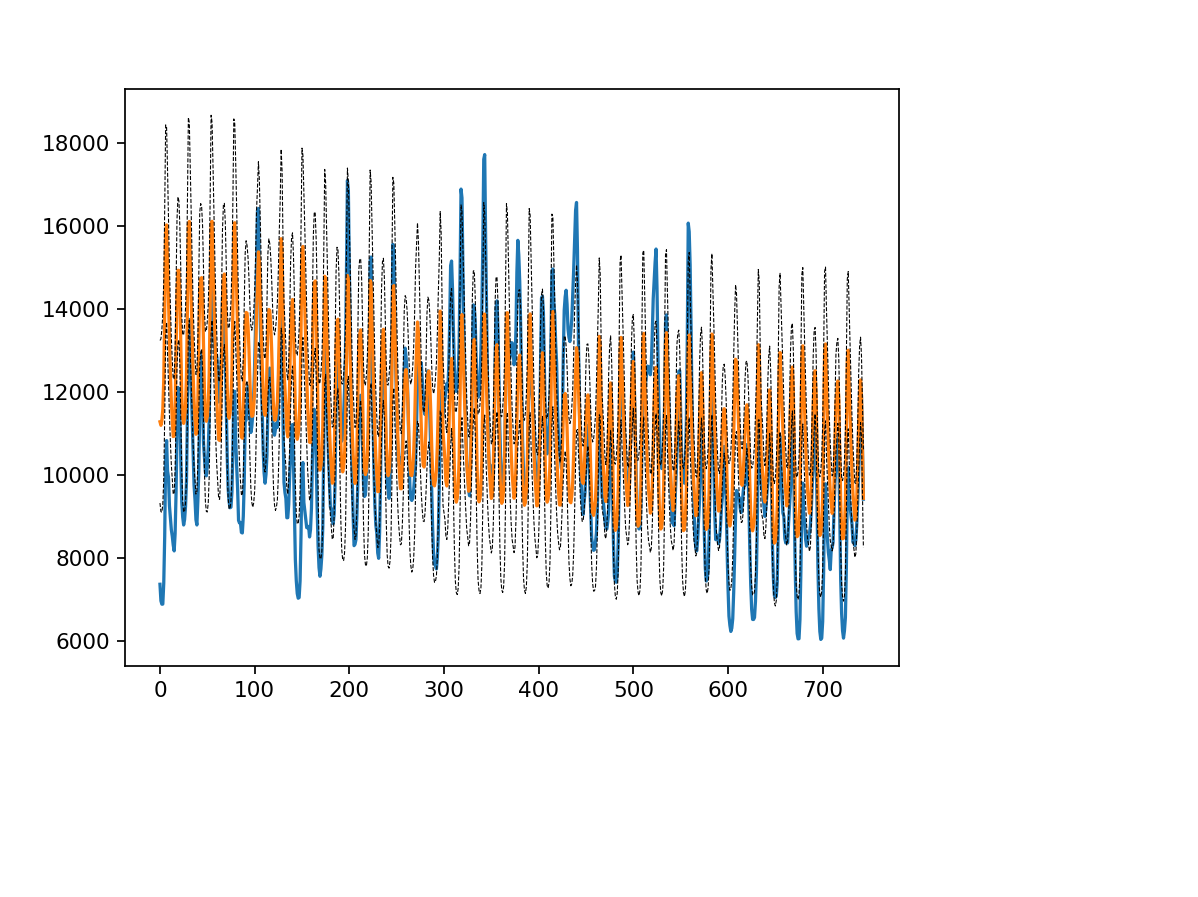

In [134]:
pred = np.mean(preds, axis=0)
std = np.std(preds, axis=0)
plt.figure(dpi=130)
plt.plot(test_demand.values)
plt.plot(pred)
plt.plot(std + pred, linestyle="--", color="black", linewidth=0.5)
plt.plot(pred - std, linestyle="--", color="black", linewidth=0.5)
plt.show()

In [135]:
quant_preds = []
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for t in range(preds.shape[1]):
    sorted_preds = np.sort(preds[:, t])
    quant_pred = []
    for q in quantiles:
        idx = int(q * preds.shape[0] + 0.5)
        quant_pred.append(sorted_preds[idx])
    quant_preds.append(quant_pred)

In [136]:
print(quant_preds[100])

[8903.815092056815, 9901.44810216548, 10597.012541334985, 11103.891605979366, 11606.843731041285, 12687.833643276877, 13408.792279749076, 14309.515603292992, 15549.72148484418]


In [137]:
pinball_loss(test_demand.values, quant_preds, quantiles)

601.7399945774231